In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

C:\Users\Administrator\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv('D:\\Năm 3 - HK1\\ML\\HW\\ung thư.csv')
data

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0
565,20.13,28.25,131.20,1261.0,0.09780,0
566,16.60,28.08,108.30,858.1,0.08455,0
567,20.60,29.33,140.10,1265.0,0.11780,0


<AxesSubplot:>

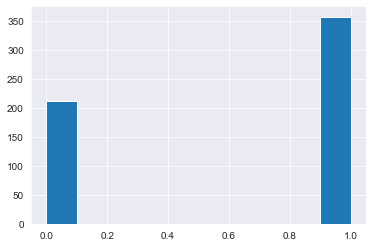

In [3]:
data['diagnosis'].hist()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB


<AxesSubplot:>

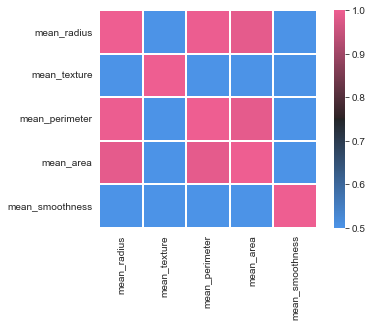

In [5]:
corr = data.iloc[:,:-1].corr(method = 'pearson')
cmap = sns.diverging_palette(250,354,80,60,center = 'dark',as_cmap = True)
sns.heatmap(corr,vmax =1,vmin=.5,cmap = cmap,square = True,linewidths = 0.2)

In [6]:
data=data.drop(columns = ['mean_perimeter','mean_area'])

Calculate P(Y=y) for all possible y

In [7]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df)) 
    return prior

approach 1: Cal P(X=x|Y=y) using Gaussian dist.

In [8]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    df = df[df[Y] == label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    #   P(X=x|Y=y)
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-((feat_val - mean)**2 / (2 * std**2)))
    return p_x_given_y

In [9]:
def naive_bayes_gaussian(df, X, Y): # array X, Y column's name
    feature = list(df.columns)[:-1] # not include Y col
    
    #Calculate prior
    prior = calculate_prior(df, Y)
    
    Y_pred = []
    
    for x in X: #có n row thì chạy hết n lần
        #calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for i in range(len(labels)): # phân loại Y
            for j in range(len(feature)):   #số cột X
                #P(X=x|Y) = P(x1|Y)*P(x2|Y)*...*P(xn|Y)
                likelihood[i] *= calculate_likelihood_gaussian(df, feature[j], x[j], Y, labels[i]) 
    
        #calculate posterior
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))
    
    return np.array(Y_pred)

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = .2, random_state = 41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X = X_test, Y='diagnosis')

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[36  4]
 [ 0 74]]
0.9736842105263158


In [11]:
data

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,17.99,10.38,0.11840,0
1,20.57,17.77,0.08474,0
2,19.69,21.25,0.10960,0
3,11.42,20.38,0.14250,0
4,20.29,14.34,0.10030,0
...,...,...,...,...
564,21.56,22.39,0.11100,0
565,20.13,28.25,0.09780,0
566,16.60,28.08,0.08455,0
567,20.60,29.33,0.11780,0


In [12]:
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    df = df[df[Y] == label]
    #   P(X=x|Y=y)
    p_x_given_y = len(df[df[feat_name]==feat_val])/len(df)
    return p_x_given_y
def naive_bayes_categorical(df, X, Y): # array X, Y column's name
    feature = list(df.columns)[:-1] # not include Y col
    
    #Calculate prior
    prior = calculate_prior(df, Y)
    
    Y_pred = []
    
    for x in X: #có n row thì chạy hết n lần
        #calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for i in range(len(labels)): # phân loại Y
            for j in range(len(feature)):   #số cột X
                #P(X=x|Y) = P(x1|Y)*P(x2|Y)*...*P(xn|Y)
                likelihood[i] *= calculate_likelihood_categorical(df, feature[j], x[j], Y, labels[i]) 
    
        #calculate posterior
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))
    
    return np.array(Y_pred)

In [13]:
data2 = data.copy()
data2

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,17.99,10.38,0.11840,0
1,20.57,17.77,0.08474,0
2,19.69,21.25,0.10960,0
3,11.42,20.38,0.14250,0
4,20.29,14.34,0.10030,0
...,...,...,...,...
564,21.56,22.39,0.11100,0
565,20.13,28.25,0.09780,0
566,16.60,28.08,0.08455,0
567,20.60,29.33,0.11780,0


In [14]:
data2.mean_radius = pd.cut(data2.mean_radius.values,bins=3,labels=[0,1,2])
data2.mean_texture = pd.cut(data2.mean_texture.values,bins=3,labels=[0,1,2])
data2.mean_smoothness = pd.cut(data2.mean_smoothness.values,bins=3,labels=[0,1,2])
data2

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,1,0,1,0
1,1,0,0,0
2,1,1,1,0
3,0,1,2,0
4,1,0,1,0
...,...,...,...,...
564,2,1,1,0
565,1,1,1,0
566,1,1,0,0
567,1,1,1,0


In [15]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data2, test_size = .2, random_state = 41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_categorical(train, X = X_test, Y='diagnosis')

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[38  2]
 [ 5 69]]
0.9517241379310345
